In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip -q /content/drive/MyDrive/Jupyter/CS539/ECE539_Jersey_Detection/jersey_images.zip \
       -d /content/jersey_images


In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torch

In [5]:
numbers = pd.read_csv("/content/drive/MyDrive/Jupyter/CS539/ECE539_Jersey_Detection/train_player_numbers.csv")
numbers.head()

,filename,video_frame,player,label,left,top,right,bottom,filepath
0,58000_001306_Sideline_240_V84.png,58000_001306_Sideline_240,V84,84,826,137,890,201,train_player_numbers/58000_001306_Sideline_240...
1,58095_004022_Endzone_140_H24.png,58095_004022_Endzone_140,H24,24,592,323,656,387,train_player_numbers/58095_004022_Endzone_140_...
2,58094_002819_Sideline_200_V83.png,58094_002819_Sideline_200,V83,83,749,309,813,373,train_player_numbers/58094_002819_Sideline_200...
3,57594_000923_Sideline_240_V23.png,57594_000923_Sideline_240,V23,23,585,76,649,140,train_player_numbers/57594_000923_Sideline_240...
4,57680_003470_Endzone_260_V72.png,57680_003470_Endzone_260,V72,72,530,189,594,253,train_player_numbers/57680_003470_Endzone_260_...


In [15]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])
all_image_paths = numbers.loc[:,"filepath"].values
# Example: Initialize dataset

unique_numbers = sorted(numbers['label'].unique())
jersey_to_idx = {num: idx for idx, num in enumerate(unique_numbers)}
idx_to_jersey = {idx: num for num, idx in jersey_to_idx.items()}

# Apply mapping
mapped_labels = [jersey_to_idx[label] for label in numbers['label']]

dataset = JerseyNumberDataset(image_paths=all_image_paths, labels=mapped_labels, transform=transform)


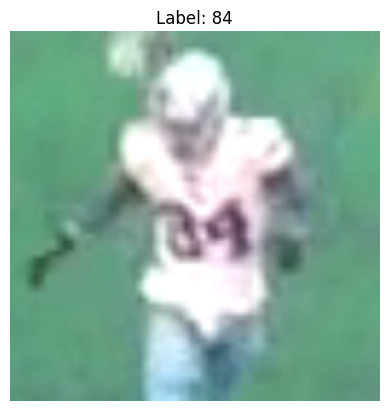

In [16]:
import matplotlib.pyplot as plt
img_tensor, label = dataset[0]


img_np = img_tensor.permute(1, 2, 0).numpy()

# Plot
plt.imshow(img_np)
plt.title(f"Label: {label.item()}")
plt.axis('off')
plt.show()

In [17]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Jupyter/CS539/ECE539_Jersey_Detection/train_player_numbers.csv')
df['filepath'] = df['filename'].apply(lambda x: f"/content/jersey_images/train_player_numbers/{x}")

assert df['label'].min() == 0 and df['label'].max() == 99
num_classes = 100


train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


IMG_SIZE = (64, 64)
BATCH_SIZE = 64


def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label


def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_df['filepath'].values, train_df['label'].values, training=True)
val_ds = make_dataset(val_df['filepath'].values, val_df['label'].values, training=False)


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_ds, validation_data=val_ds, epochs=50)


loss, acc = model.evaluate(val_ds)
print(f"\n Validation Accuracy: {acc:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


549/549 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.0222 - loss: 4.4982 - val_accuracy: 0.0483 - val_loss: 4.2940
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0423 - loss: 4.2704 - val_accuracy: 0.0621 - val_loss: 4.0930
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.0651 - loss: 4.0609 - val_accuracy: 0.0839 - val_loss: 3.9279
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.0964 - loss: 3.8186 - val_accuracy: 0.0951 - val_loss: 3.8649
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.1349 - loss: 3.5785 - val_accuracy: 0.1069 - val_loss: 3.8111
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.1734 - loss: 3.3430 - val_accuracy: 0.1116 - val_loss: 3.7929
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.2146 - loss: 3.0940 - val_accuracy: 0.1216 - val_loss: 3.8010
Epoch 8/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.2576 - loss: 2.8640 - val_accurac

KeyboardInterrupt: 

In [19]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/Jupyter/CS539/ECE539_Jersey_Detection/train_player_numbers.csv')
df['filepath'] = df['filename'].apply(lambda x: f"/content/jersey_images/train_player_numbers/{x}")


num_classes = 100


train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


IMG_SIZE = (299, 299)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label


def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df['filepath'].values, train_df['label'].values, training=True)
val_ds = make_dataset(val_df['filepath'].values, val_df['label'].values, training=False)


base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

# Creating a new classifier head on top of InceptionV3
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(train_ds, validation_data=val_ds, epochs=10)


loss, acc = model.evaluate(val_ds)
print(f"\nValidation Accuracy: {acc:.4f}")


Epoch 1/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 196s 167ms/step - accuracy: 0.0273 - loss: 4.7872 - val_accuracy: 0.0544 - val_loss: 4.2333
Epoch 2/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 170s 153ms/step - accuracy: 0.0646 - loss: 4.2994 - val_accuracy: 0.0786 - val_loss: 4.1082
Epoch 3/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 169s 153ms/step - accuracy: 0.0781 - loss: 4.1598 - val_accuracy: 0.0864 - val_loss: 4.0105
Epoch 4/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 190s 142ms/step - accuracy: 0.0898 - loss: 4.0933 - val_accuracy: 0.0922 - val_loss: 3.9804
Epoch 5/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 169s 153ms/step - accuracy: 0.0970 - loss: 4.0635 - val_accuracy: 0.0929 - val_loss: 3.9928
Epoch 6/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 168s 152ms/step - accuracy: 0.0999 - loss: 4.0643 - val_accuracy: 0.0970 - val_loss: 4.0065
Epoch 7/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 171s 155ms/step - accuracy: 0.1054 - loss: 4.0282 - val_accuracy: 0.1003 - val_loss: 3.9364
Epoch 8/10
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 201s 154ms/step - ac